In [1]:
import pandas as pd
import numpy as np
from collections import Counter 
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)

### 1. load dataset (captions)

In [2]:
df = pd.read_csv("data/captions.txt", sep=',')
print(len(df))
display(df.head(3))

40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


### 2. Preprocessing the text

In [3]:
#remove single char word
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [4]:
# add start and end tags for captions

df['cleaned_caption'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [5]:
df.head(3)

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[<start>, little, girl, climbing, into, wooden, playhouse, <end>]"


In [5]:
#calc max length of captions for padding
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

33


In [6]:
#add padding to captions
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

In [7]:
display(df.head(2))

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


In [8]:
#create word dictionary ({word: total frequency})
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [9]:
print(len(word_dict))
print(word_dict[:5])

8360
['<pad>', '<start>', '<end>', 'in', 'the']


In [10]:
#set vocab size
vocab_size = len(word_dict)
print(vocab_size)

8360


In [25]:
for index, word in enumerate(word_dict):
    print(index, word)

0 <pad>
1 <start>
2 <end>
3 in
4 the
5 on
6 is
7 and
8 dog
9 with
10 man
11 of
12 two
13 white
14 black
15 boy
16 are
17 woman
18 girl
19 to
20 wearing
21 at
22 people
23 water
24 red
25 young
26 brown
27 an
28 his
29 blue
30 dogs
31 running
32 through
33 playing
34 while
35 down
36 shirt
37 standing
38 ball
39 little
40 grass
41 child
42 person
43 snow
44 jumping
45 over
46 front
47 three
48 sitting
49 holding
50 field
51 small
52 up
53 by
54 large
55 green
56 group
57 one
58 yellow
59 her
60 walking
61 children
62 men
63 into
64 air
65 beach
66 near
67 mouth
68 jumps
69 another
70 for
71 street
72 runs
73 its
74 from
75 riding
76 stands
77 as
78 bike
79 girls
80 outside
81 other
82 out
83 rock
84 next
85 play
86 off
87 looking
88 orange
89 pink
90 player
91 their
92 camera
93 pool
94 hat
95 jacket
96 boys
97 women
98 around
99 behind
100 some
101 background
102 dirt
103 toy
104 soccer
105 sits
106 dressed
107 has
108 wall
109 mountain
110 walks
111 crowd
112 along
113 plays
114 stand

In [11]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8360 8360


In [12]:
# Save them for later use in inference
import pickle
with open('data/word_to_index.pkl', 'wb') as f:
    pickle.dump(word_to_index, f)
with open('data/index_to_word.pkl', 'wb') as f:
    pickle.dump(index_to_word, f)

In [13]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [29]:
display(df.head(2))

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


1 - start, 2 - end, 0 - pad

other words are mapped to a unique integer

In [14]:
#train - val split (90, 10)
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]

In [15]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())

36409 7282
4046 810


In [16]:
train_samples = len(train)
print(train_samples)

36409


In [17]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

7282 810


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

cpu


*skip below part and go to Step 10 if just testing the model

### 3. Apply basic transformations to image data

In [44]:
class extractImageFeatureResNetDataSet():
    #apply necessary transformations and return image tensor
    def __init__(self, data):
        self.data = data 
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = 'data/Images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [45]:
#create dataloaders for train image datasets
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [46]:
#create dataloaders for val image datasets
valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

### 4. Initialize pre-trained model

In [48]:
#initialize pretrained ResNet model
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [49]:
#get last layer of ResNet model
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [ ]:
resNet18Layer4

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

### 5. Extract feature vectors from transformed image tensors

In [54]:
#function to get image feature vector from ResNet model
def get_vector(t_img):
    
    # 1. input to pytorch variable
    # t_img = Variable(t_img)
    t_img = t_img.requires_grad_(False)

    # 2. Create a tensor to store the hook output
    my_embedding = torch.zeros(1, 512, 7, 7)

    # 3. Define the hook function (to copy the output to the tensor created in step 2)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    # 4. Register hook on ResNet layer
    h = resNet18Layer4.register_forward_hook(copy_data)

    # 5. Forward pass
    resnet18(t_img)
    
    # 6. Remove hook (prevents the hook from persisting unexpectedly for future runs)
    h.remove()
    return my_embedding

#### train data

In [55]:
#extract image features for train images
extract_img_featr_ResNet_train = {}
for image_name, t_img in tqdm.tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
    
    extract_img_featr_ResNet_train[image_name[0]] = embdg
    

100%|██████████| 7282/7282 [01:38<00:00, 74.14it/s]


In [ ]:
#save train image features for easy access in future training
a_file = open("data/EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_img_featr_ResNet_train, a_file)
a_file.close()

#### val data

In [58]:
#extract image features for val images
extract_img_featr_ResNet_valid = {}
for image_name, t_img in tqdm.tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
 
    extract_img_featr_ResNet_valid[image_name[0]] = embdg

100%|██████████| 810/810 [00:11<00:00, 69.95it/s]


In [ ]:
#save val image features for easy access
a_file = open("data/EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_img_featr_ResNet_valid, a_file)
a_file.close()

### 6. Create final dataset class (captions + images) 
with necessary flattening and dimension reordering

In [ ]:
#create dataset class for train and val datasets
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #get caption sequence and target sequence
        caption_seq = self.data.iloc[idx]['text_seq']
        #skip start tag and create target sequence
        target_seq = caption_seq[1:]+[0]

        #get image tensor
        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]

        #reorder dimensions for attention model (that expects features in last dim)
        image_tensor = image_tensor.permute(0,2,3,1)
        #Flatten H×W dimensions ([1, 7, 7, 512] -> [1, 49, 512])
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [64]:
train_dataset_resnet = FlickerDataSetResnet(train, 'data/EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [65]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'data/EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

### 7. Create Positional Encoding for captions

In [66]:
#Positional Encoding class
class PositionalEncoding(nn.Module):
    ''' 
    Implements positional encoding as described in "Attention is All You Need".
    Adds sinusoidal positional information to word embeddings to capture word order.
    This helps the Transformer model understand the sequence of words.
    '''
    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

### 8. Create the final model, ImageCaptionModel

In [67]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        '''
        Initializes the image captioning Transformer model.
        - Creates word embedding layer
        - Adds positional encoding to capture word order
        - Builds Transformer Decoder layers
        - Adds final linear layer to predict next word
        - Initializes model weights
        '''
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        '''
        Initializes the model weights:
        - Embeddings and linear layer weights are set to small random values
        - Output layer bias is set to zero
        Helps stabilize training and prevents poor initial gradients.
        '''
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        '''
        Generates the masks required for Transformer decoding:
        1. Causal mask (decoder_input_mask):
           - Prevents the decoder from looking at future words
        2. Padding mask (decoder_input_pad_mask_bool):
           - Ignores <pad> tokens during attention
        Ensures fair, autoregressive caption generation.
        '''
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        '''
        Forward pass of the captioning model:
        Steps:
        1. Reshape encoded image features for Transformer
        2. Embed input caption tokens
        3. Add positional encoding to maintain word order
        4. Generate causal & padding masks for decoding
        5. Decode caption using image features + transformer decoder
        6. Apply final linear layer to predict the next word at each position

        Returns:
        - final_output: vocabulary logits for each time step
        - decoder_input_pad_mask: used later for masking loss
        '''
        encoded_image = encoded_image.permute(1,0,2)
        

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        
        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

#### training epochs

In [68]:
EPOCH = 30

#### init the final model

In [69]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = float('Inf')

In [ ]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)  # Open Multilingual Wordnet

True

In [74]:
# Simple tokenizer class for the evaluation function
class SimpleTokenizer:
    def __init__(self, index_to_word_dict):
        self.index_to_word = index_to_word_dict
    
    def decode(self, token_id):
        return self.index_to_word.get(token_id, '<unk>')

# Create tokenizer instance
tokenizer = SimpleTokenizer(index_to_word)

In [76]:
# Get one batch
caption_seq, target_seq, image_embed = next(iter(valid_dataloader_resnet))

# Decode first caption
first_caption_ids = caption_seq[0].tolist()
print("Encoded caption IDs:", first_caption_ids)
decoded = [tokenizer.decode(id) for id in first_caption_ids]
print("Decoded caption:", ' '.join(decoded))

Encoded caption IDs: [1, 18, 871, 19, 515, 289, 431, 35, 74, 977, 676, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded caption: <start> girl appears to be hanging upside down from jungle gym <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


### 9. Run and train

In [78]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import json

In [80]:
# Initialize metric tracking
metrics_history = {
    'train_loss': [],
    'val_loss': [],
    'bleu1': [],
    'bleu2': [],
    'bleu3': [],
    'bleu4': [],
    'meteor': [],
    'rouge_l': []
}

def calculate_bleu_scores(references, hypotheses):
    """Calculate BLEU-1, BLEU-2, BLEU-3, BLEU-4 scores"""
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    return bleu1, bleu2, bleu3, bleu4

def calculate_meteor(references, hypotheses):
    """Calculate METEOR score"""
    scores = []
    for ref, hyp in zip(references, hypotheses):
        # ref is [[word1, word2, ...]], hyp is [word1, word2, ...]
        # METEOR expects lists of tokens, not strings
        if len(hyp) == 0:
            scores.append(0.0)
            continue
        try:
            score = meteor_score([ref[0]], hyp)
            scores.append(score)
        except:
            scores.append(0.0)
    return np.mean(scores) if scores else 0.0

def calculate_rouge(references, hypotheses):
    """Calculate ROUGE-L score"""
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = []
    for ref, hyp in zip(references, hypotheses):
        # ROUGE expects strings
        ref_text = ' '.join(ref[0])
        hyp_text = ' '.join(hyp)
        if len(hyp_text.strip()) == 0:
            scores.append(0.0)
            continue
        try:
            score = scorer.score(ref_text, hyp_text)
            scores.append(score['rougeL'].fmeasure)
        except:
            scores.append(0.0)
    return np.mean(scores) if scores else 0.0

def decode_predictions(output_logits, tokenizer, max_len=50):
    """Decode model outputs to list of tokens (words)"""
    # Handle different input shapes
    if len(output_logits.shape) == 3:  # [batch, vocab_size, seq_len]
        predictions = torch.argmax(output_logits, dim=1)  # [batch, seq_len]
    else:  # [vocab_size, seq_len] or [seq_len]
        predictions = torch.argmax(output_logits, dim=0) if len(output_logits.shape) == 2 else output_logits
    
    decoded = []
    # Ensure predictions is 2D [batch, seq_len]
    if len(predictions.shape) == 1:
        predictions = predictions.unsqueeze(0)
    
    for pred in predictions:  # Iterate over batch
        tokens = []
        for token_id in pred:
            token_id_val = token_id.item() if torch.is_tensor(token_id) else token_id
            word = tokenizer.decode(token_id_val)
            
            # Stop at end tokens
            if word == '<end>' or word == '<pad>':
                break
            # Skip start token
            if word != '<start>':
                tokens.append(word)
        
        decoded.append(tokens)
    return decoded

def evaluate_metrics(model, dataloader, tokenizer, device, max_samples=500):
    """Comprehensive evaluation with BLEU, METEOR, ROUGE"""
    model.eval()
    all_references = []
    all_hypotheses = []
    
    with torch.no_grad():
        for idx, (caption_seq, target_seq, image_embed) in enumerate(dataloader):
            if idx >= max_samples:  # Limit for faster evaluation
                break
                
            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)
            
            # Get model predictions
            output, _ = model.forward(image_embed, caption_seq)
            
            # Decode predictions and references
            hypotheses_batch = decode_predictions(output, tokenizer)
            references_batch = decode_predictions(target_seq, tokenizer)
            
            # Add to collections
            for hyp, ref in zip(hypotheses_batch, references_batch):
                all_hypotheses.append(hyp)
                all_references.append([ref])  # BLEU expects list of reference lists
    
    # Calculate all metrics
    bleu1, bleu2, bleu3, bleu4 = calculate_bleu_scores(all_references, all_hypotheses)
    meteor = calculate_meteor(all_references, all_hypotheses)
    rouge_l = calculate_rouge(all_references, all_hypotheses)
    
    return {
        'bleu1': bleu1,
        'bleu2': bleu2,
        'bleu3': bleu3,
        'bleu4': bleu4,
        'meteor': meteor,
        'rouge_l': rouge_l
    }

def save_metrics(metrics_history, epoch, save_path='data/metrics_history.json'):
    """Save metrics history to JSON file"""
    # Convert tensors to float for JSON serialization
    json_data = {k: [float(v) for v in vals] for k, vals in metrics_history.items()}
    json_data['last_epoch'] = epoch
    
    with open(save_path, 'w') as f:
        json.dump(json_data, f, indent=2)
    print(f"✓ Metrics saved to {save_path}")

# Enhanced Training Loop
for epoch in tqdm.tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:
        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output, target_seq)
        loss_masked = torch.mul(loss, padding_mask)
        final_batch_loss = torch.sum(loss_masked) / torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach()
        total_train_words += torch.sum(padding_mask)

    total_epoch_train_loss = total_epoch_train_loss / total_train_words

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:
            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output, target_seq)
            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss / total_valid_words

    # Calculate evaluation metrics every epoch (or every N epochs for efficiency)
    if epoch % 1 == 0:  # Change to % 5 for every 5 epochs
        eval_metrics = evaluate_metrics(ictModel, valid_dataloader_resnet, tokenizer, device)
        
        # Store metrics
        metrics_history['train_loss'].append(total_epoch_train_loss.item())
        metrics_history['val_loss'].append(total_epoch_valid_loss.item())
        metrics_history['bleu1'].append(eval_metrics['bleu1'])
        metrics_history['bleu2'].append(eval_metrics['bleu2'])
        metrics_history['bleu3'].append(eval_metrics['bleu3'])
        metrics_history['bleu4'].append(eval_metrics['bleu4'])
        metrics_history['meteor'].append(eval_metrics['meteor'])
        metrics_history['rouge_l'].append(eval_metrics['rouge_l'])
        
        print(f"\nEpoch {epoch}")
        print(f"Train Loss: {total_epoch_train_loss:.4f} | Val Loss: {total_epoch_valid_loss:.4f}")
        print(f"BLEU-1: {eval_metrics['bleu1']:.4f} | BLEU-4: {eval_metrics['bleu4']:.4f}")
        print(f"METEOR: {eval_metrics['meteor']:.4f} | ROUGE-L: {eval_metrics['rouge_l']:.4f}")

    # Save best model
    if min_val_loss > total_epoch_valid_loss:
        print(f"✓ New best model at epoch {epoch}")
        torch.save(ictModel, 'data/BestModel')
        min_val_loss = total_epoch_valid_loss

    scheduler.step(total_epoch_valid_loss.item())
    
    # Save metrics after each epoch
    save_metrics(metrics_history, epoch)

# Final save
print("\n" + "="*50)
print("Training Complete! Metrics saved to data/metrics_history.json")
print("="*50)

  0%|          | 0/30 [00:00<?, ?it/s]/Users/pradyumnakumar/miniconda3/envs/vision/lib/python3.12/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/Users/pradyumnakumar/miniconda3/envs/vision/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/pradyumnakumar/miniconda3/envs/vision/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.w


Epoch 0
Train Loss: 3.9214 | Val Loss: 3.8111
BLEU-1: 0.1353 | BLEU-4: 0.0000
METEOR: 0.0979 | ROUGE-L: 0.1030
✓ New best model at epoch 0


  3%|▎         | 1/30 [06:49<3:17:44, 409.13s/it]

✓ Metrics saved to data/metrics_history.json

Epoch 1
Train Loss: 3.7264 | Val Loss: 3.6820
BLEU-1: 0.1254 | BLEU-4: 0.0000
METEOR: 0.0903 | ROUGE-L: 0.0979
✓ New best model at epoch 1


  7%|▋         | 2/30 [13:39<3:11:08, 409.59s/it]

✓ Metrics saved to data/metrics_history.json


 10%|█         | 3/30 [20:28<3:04:14, 409.44s/it]


Epoch 2
Train Loss: 3.5831 | Val Loss: 3.5908
BLEU-1: 0.1371 | BLEU-4: 0.0000
METEOR: 0.0939 | ROUGE-L: 0.1019
✓ New best model at epoch 2
✓ Metrics saved to data/metrics_history.json


 13%|█▎        | 4/30 [27:19<2:57:39, 409.99s/it]


Epoch 3
Train Loss: 3.4663 | Val Loss: 3.5218
BLEU-1: 0.1240 | BLEU-4: 0.0000
METEOR: 0.0998 | ROUGE-L: 0.1020
✓ New best model at epoch 3
✓ Metrics saved to data/metrics_history.json


 17%|█▋        | 5/30 [34:42<2:55:47, 421.89s/it]


Epoch 4
Train Loss: 3.3694 | Val Loss: 3.4680
BLEU-1: 0.1173 | BLEU-4: 0.0000
METEOR: 0.0901 | ROUGE-L: 0.0979
✓ New best model at epoch 4
✓ Metrics saved to data/metrics_history.json


 20%|██        | 6/30 [42:58<2:58:52, 447.17s/it]


Epoch 5
Train Loss: 3.2833 | Val Loss: 3.4227
BLEU-1: 0.1397 | BLEU-4: 0.0000
METEOR: 0.0900 | ROUGE-L: 0.0975
✓ New best model at epoch 5
✓ Metrics saved to data/metrics_history.json


 23%|██▎       | 7/30 [51:03<2:56:10, 459.60s/it]


Epoch 6
Train Loss: 3.2078 | Val Loss: 3.3810
BLEU-1: 0.1350 | BLEU-4: 0.0000
METEOR: 0.0993 | ROUGE-L: 0.1074
✓ New best model at epoch 6
✓ Metrics saved to data/metrics_history.json


 27%|██▋       | 8/30 [59:10<2:51:44, 468.37s/it]


Epoch 7
Train Loss: 3.1387 | Val Loss: 3.3489
BLEU-1: 0.1490 | BLEU-4: 0.0000
METEOR: 0.0856 | ROUGE-L: 0.1008
✓ New best model at epoch 7
✓ Metrics saved to data/metrics_history.json


 30%|███       | 9/30 [1:07:14<2:45:33, 473.04s/it]


Epoch 8
Train Loss: 3.0759 | Val Loss: 3.3255
BLEU-1: 0.1328 | BLEU-4: 0.0000
METEOR: 0.0865 | ROUGE-L: 0.0951
✓ New best model at epoch 8
✓ Metrics saved to data/metrics_history.json


 33%|███▎      | 10/30 [1:14:29<2:33:47, 461.35s/it]


Epoch 9
Train Loss: 3.0179 | Val Loss: 3.3008
BLEU-1: 0.1199 | BLEU-4: 0.0000
METEOR: 0.1094 | ROUGE-L: 0.1149
✓ New best model at epoch 9
✓ Metrics saved to data/metrics_history.json


 37%|███▋      | 11/30 [1:21:34<2:22:33, 450.21s/it]


Epoch 10
Train Loss: 2.9617 | Val Loss: 3.2889
BLEU-1: 0.1318 | BLEU-4: 0.0000
METEOR: 0.0858 | ROUGE-L: 0.0948
✓ New best model at epoch 10
✓ Metrics saved to data/metrics_history.json


 40%|████      | 12/30 [1:28:42<2:13:04, 443.61s/it]


Epoch 11
Train Loss: 2.9120 | Val Loss: 3.2714
BLEU-1: 0.1305 | BLEU-4: 0.0000
METEOR: 0.1043 | ROUGE-L: 0.1124
✓ New best model at epoch 11
✓ Metrics saved to data/metrics_history.json


 43%|████▎     | 13/30 [1:36:24<2:07:15, 449.16s/it]


Epoch 12
Train Loss: 2.8624 | Val Loss: 3.2568
BLEU-1: 0.1465 | BLEU-4: 0.0000
METEOR: 0.0852 | ROUGE-L: 0.0966
✓ New best model at epoch 12
✓ Metrics saved to data/metrics_history.json


 47%|████▋     | 14/30 [1:43:50<1:59:29, 448.11s/it]


Epoch 13
Train Loss: 2.8149 | Val Loss: 3.2466
BLEU-1: 0.1464 | BLEU-4: 0.0000
METEOR: 0.1015 | ROUGE-L: 0.1096
✓ New best model at epoch 13
✓ Metrics saved to data/metrics_history.json


 50%|█████     | 15/30 [1:51:09<1:51:20, 445.38s/it]


Epoch 14
Train Loss: 2.7696 | Val Loss: 3.2357
BLEU-1: 0.1402 | BLEU-4: 0.0000
METEOR: 0.0829 | ROUGE-L: 0.0898
✓ New best model at epoch 14
✓ Metrics saved to data/metrics_history.json


 53%|█████▎    | 16/30 [1:58:29<1:43:33, 443.82s/it]


Epoch 15
Train Loss: 2.7256 | Val Loss: 3.2278
BLEU-1: 0.1323 | BLEU-4: 0.0000
METEOR: 0.0934 | ROUGE-L: 0.1197
✓ New best model at epoch 15
✓ Metrics saved to data/metrics_history.json

Epoch 16
Train Loss: 2.6844 | Val Loss: 3.2242
BLEU-1: 0.1577 | BLEU-4: 0.0000
METEOR: 0.0982 | ROUGE-L: 0.1032
✓ New best model at epoch 16


 57%|█████▋    | 17/30 [2:05:49<1:35:54, 442.68s/it]

✓ Metrics saved to data/metrics_history.json

Epoch 17
Train Loss: 2.6439 | Val Loss: 3.2161
BLEU-1: 0.1706 | BLEU-4: 0.0000
METEOR: 0.0927 | ROUGE-L: 0.1143
✓ New best model at epoch 17


 60%|██████    | 18/30 [2:13:05<1:28:06, 440.56s/it]

✓ Metrics saved to data/metrics_history.json


 63%|██████▎   | 19/30 [2:20:24<1:20:40, 440.09s/it]


Epoch 18
Train Loss: 2.6035 | Val Loss: 3.2171
BLEU-1: 0.1224 | BLEU-4: 0.0000
METEOR: 0.0941 | ROUGE-L: 0.1056
✓ Metrics saved to data/metrics_history.json

Epoch 19
Train Loss: 2.5659 | Val Loss: 3.2088
BLEU-1: 0.1561 | BLEU-4: 0.0000
METEOR: 0.0975 | ROUGE-L: 0.1180
✓ New best model at epoch 19


 67%|██████▋   | 20/30 [2:27:45<1:13:24, 440.47s/it]

✓ Metrics saved to data/metrics_history.json


 70%|███████   | 21/30 [2:34:50<1:05:23, 435.92s/it]


Epoch 20
Train Loss: 2.5266 | Val Loss: 3.2103
BLEU-1: 0.1602 | BLEU-4: 0.0000
METEOR: 0.0988 | ROUGE-L: 0.1117
✓ Metrics saved to data/metrics_history.json

Epoch 21
Train Loss: 2.4888 | Val Loss: 3.2068
BLEU-1: 0.1338 | BLEU-4: 0.0000
METEOR: 0.0882 | ROUGE-L: 0.1003
✓ New best model at epoch 21


 73%|███████▎  | 22/30 [2:42:13<58:24, 438.08s/it]  

✓ Metrics saved to data/metrics_history.json

Epoch 22
Train Loss: 2.4537 | Val Loss: 3.2013
BLEU-1: 0.1327 | BLEU-4: 0.0000
METEOR: 0.0942 | ROUGE-L: 0.1081
✓ New best model at epoch 22


 77%|███████▋  | 23/30 [2:49:32<51:07, 438.20s/it]

✓ Metrics saved to data/metrics_history.json


 80%|████████  | 24/30 [2:56:48<43:45, 437.59s/it]


Epoch 23
Train Loss: 2.4198 | Val Loss: 3.2095
BLEU-1: 0.1501 | BLEU-4: 0.0000
METEOR: 0.0924 | ROUGE-L: 0.1078
✓ Metrics saved to data/metrics_history.json


 83%|████████▎ | 25/30 [3:04:06<36:28, 437.70s/it]


Epoch 24
Train Loss: 2.3842 | Val Loss: 3.2090
BLEU-1: 0.1638 | BLEU-4: 0.0000
METEOR: 0.1190 | ROUGE-L: 0.1285
✓ Metrics saved to data/metrics_history.json


 87%|████████▋ | 26/30 [3:11:22<29:08, 437.05s/it]


Epoch 25
Train Loss: 2.3523 | Val Loss: 3.2095
BLEU-1: 0.1553 | BLEU-4: 0.0000
METEOR: 0.0880 | ROUGE-L: 0.1080
✓ Metrics saved to data/metrics_history.json


 90%|█████████ | 27/30 [3:18:51<22:01, 440.66s/it]


Epoch 26
Train Loss: 2.3140 | Val Loss: 3.2098
BLEU-1: 0.1402 | BLEU-4: 0.0000
METEOR: 0.1055 | ROUGE-L: 0.1122
✓ Metrics saved to data/metrics_history.json


 93%|█████████▎| 28/30 [3:26:09<14:39, 439.81s/it]


Epoch 27
Train Loss: 2.2882 | Val Loss: 3.2083
BLEU-1: 0.1293 | BLEU-4: 0.0000
METEOR: 0.1068 | ROUGE-L: 0.1132
✓ Metrics saved to data/metrics_history.json


 97%|█████████▋| 29/30 [3:33:27<07:19, 439.36s/it]


Epoch 28
Train Loss: 2.2602 | Val Loss: 3.2107
BLEU-1: 0.1619 | BLEU-4: 0.0000
METEOR: 0.1027 | ROUGE-L: 0.1173
✓ Metrics saved to data/metrics_history.json


100%|██████████| 30/30 [3:40:47<00:00, 441.59s/it]


Epoch 29
Train Loss: 2.2324 | Val Loss: 3.2156
BLEU-1: 0.1385 | BLEU-4: 0.0000
METEOR: 0.1018 | ROUGE-L: 0.1246
✓ Metrics saved to data/metrics_history.json

Training Complete! Metrics saved to data/metrics_history.json


### 10. Test the model on random validation images

In [19]:
import torch
from models.ImageCaptionModel import ImageCaptionModel, PositionalEncoding  # If defined in another file

# Allow the custom class to be loaded safely
torch.serialization.add_safe_globals([ImageCaptionModel])

# Now load the model
model = torch.load("data/BestModel_50.pth",
    map_location=torch.device('cpu'),
    weights_only=False
)


model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [20]:
valid_img_embed = pd.read_pickle('data/EncodedImageValidResNet_50.pkl')

In [35]:
def generate_caption(K, img_nm): 
    img_loc = 'data/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))

# Define special tokens and sequence length
# These must match the tokens used during model training
    pad_token = word_to_index.get("<pad>", 0)      # default to 0 if not found
    start_token = word_to_index.get("<start>", 0)
    end_token = word_to_index.get("<end>", 0)

# Define maximum caption length used during training
    max_seq_len = 33  # or whatever max length your model was trained with

    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

In [21]:
def generate_caption_new(img_nm, K=5, use_sampling=False): 
    img_loc = 'data/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    
    img_embed = valid_img_embed[img_nm].to(device)
    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))

    # Special tokens
    pad_token = word_to_index["<pad>"]
    start_token = word_to_index["<start>"]
    end_token = word_to_index["<end>"]
    max_seq_len = 33

    # Initialize with start token, rest are padding
    input_seq = torch.full((1, max_seq_len), pad_token, dtype=torch.long).to(device)
    input_seq[0, 0] = start_token
    
    predicted_sentence = []
    
    with torch.no_grad():
        for eval_iter in range(max_seq_len - 1):
            # Forward pass
            output, padding_mask = model.forward(img_embed, input_seq)
            
            # Get prediction for current position
            logits = output[eval_iter, 0, :]  # [vocab_size]
            
            # Choose next word
            if use_sampling:
                # Sample from top-K (more diverse, less accurate)
                values, indices = torch.topk(logits, K)
                probs = torch.softmax(values, dim=0)
                next_word_index = indices[torch.multinomial(probs, 1)].item()
            else:
                # Greedy decoding (more accurate, less diverse)
                next_word_index = torch.argmax(logits).item()
            
            next_word = index_to_word[next_word_index]
            
            # Stop if we hit end token
            if next_word == '<end>':
                break
            
            # Skip special tokens in output
            if next_word not in ['<start>', '<pad>']:
                predicted_sentence.append(next_word)
            
            # Update input sequence for next iteration
            if eval_iter + 1 < max_seq_len:
                input_seq[0, eval_iter + 1] = next_word_index
    
    print("\nPredicted caption:")
    print(" ".join(predicted_sentence))
    print()
    return " ".join(predicted_sentence)

# Usage:
# generate_caption('example.jpg', K=5, use_sampling=False)  # Greedy (best for accuracy)
# generate_caption('example.jpg', K=5, use_sampling=True)   # Sampling (more diverse)

Actual Caption : 
['A toddler starting at a clown walking down a snowy sidewalk .', 'Several people including a child and a clown are walking towards a snowy sidewalk', 'Three adults and a toddler stand on a snowy path .', 'Three adults and one child are walking along a paved path that is snow covered .', 'Two adults , a child , and a clown walking down a sidewalk .']


Predicted caption : 
three people are standing on snowy hill .


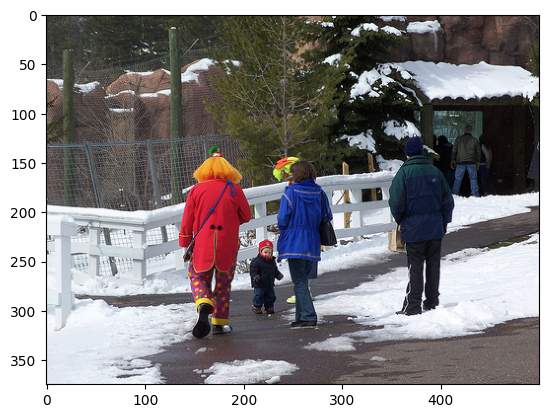

In [ ]:
# model trained with 50 epochs
generate_caption(3, unq_valid_imgs.iloc[76]['image'])

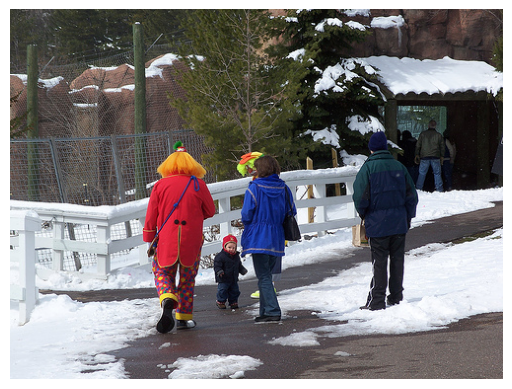

Actual Caption : 
['A toddler starting at a clown walking down a snowy sidewalk .', 'Several people including a child and a clown are walking towards a snowy sidewalk', 'Three adults and a toddler stand on a snowy path .', 'Three adults and one child are walking along a paved path that is snow covered .', 'Two adults , a child , and a clown walking down a sidewalk .']

Predicted caption:
two people stand in the middle of winter clothes are looking at something



'two people stand in the middle of winter clothes are looking at something'

In [ ]:
# model trained with 30 epochs
generate_caption_new(unq_valid_imgs.iloc[76]['image'], K=5, use_sampling=True)

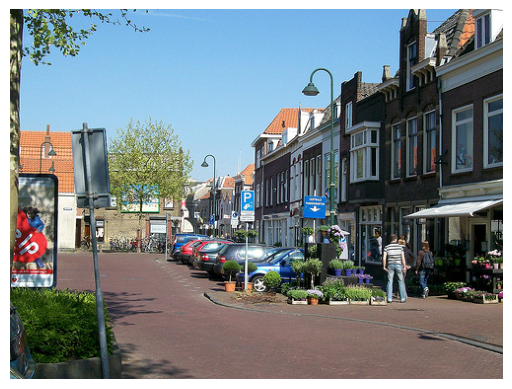

Actual Caption : 
['There are two blue signs on the corner of the street .', 'People stand outside of a building that has cars parked in front .', 'Cobblestone street and line of storefronts', 'A street view with cars and buildings .', 'cars are parked by a little store in quaint European street .']

Predicted caption:
people are walking on the street with city street



'people are walking on the street with city street'

In [43]:
generate_caption_new(unq_valid_imgs.iloc[105]['image'], K=5, use_sampling=True)

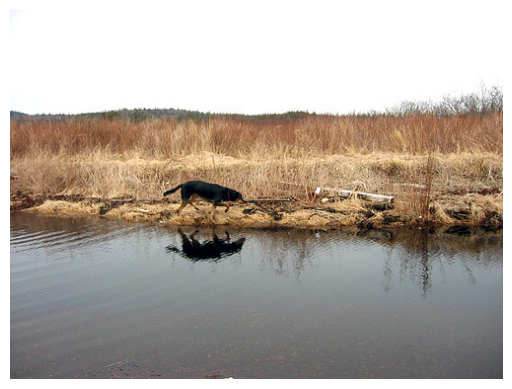

Actual Caption : 
['A dog is walking near a body of water .', "A big , black dog is walking along the water 's edge .", 'A black dog and its reflection are seen near a pond ringed by dry foliage .', 'A black dog is walking beside water in the woods .', "A black dog walks along a marsh 's edge ."]

Predicted caption:
dog jumps into the water from lake at the edge



'dog jumps into the water from lake at the edge'

In [49]:
generate_caption_new(unq_valid_imgs.iloc[88]['image'], K=5, use_sampling=True)

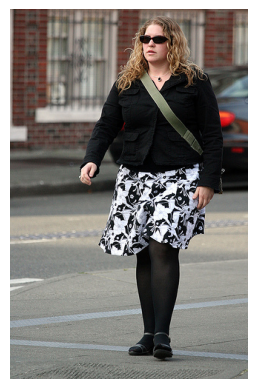

Actual Caption : 
['woman in black and sunglasses standing in road', 'a woman with a bag around her standing in the street', 'A woman wearing black and white crossing a road .', 'A woman in a black jacket and black and white skirt walks down the street .', 'A woman in a dark jacket and black and white skirt walks down the street .']

Predicted caption:
woman in black dress is walking down the street



/Users/pradyumnakumar/miniconda3/envs/vision/lib/python3.12/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


'woman in black dress is walking down the street'

In [47]:
generate_caption_new(unq_valid_imgs.iloc[452]['image'], K=5, use_sampling=True)